In [20]:
import pandas as pd
from scipy import stats
from scipy.spatial import distance
# from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_squared_error

import pickle
# Different Scalers for transcripts and methylations
TPMscaler = StandardScaler()
Methscaler = StandardScaler()

In [5]:
import os
os.getcwd()

'/home/ansar/projects/Transfer/MethPred/EnsembleAnalysis/GenesBasedPrediction'

In [ ]:
TCGAtpm = pd.read_pickle('TCGA_TPM.pkl')
TCGAtpm = TCGAtpm.set_index('sample')
TCGAtpm = TCGAtpm.astype('float32')

In [46]:
MethTCGA = pd.read_pickle('../../pancan_methylation.pkl')
MethTCGA = MethTCGA.T
MethTCGA = MethTCGA.astype('float16')

In [47]:
TCGAphenotype = pd.read_table('../../TCGA_phenotype_denseDataOnlyDownload.tsv.gz', compression='gzip')
TCGAphenotype = TCGAphenotype.set_index('sample')

In [52]:
CommPatients = MethTCGA.columns.intersection(TCGAtpm.columns).intersection(TCGAphenotype.index)
MethTCGA = MethTCGA[CommPatients]
TCGAtpm = TCGAtpm[CommPatients]
TCGAphenotype = TCGAphenotype.loc[CommPatients]

In [8]:
# Methylation Annotations
Meth450Annotations = pd.read_table('../../HM450.hg38.manifest.gencode.v22.tsv.gz', compression='gzip', low_memory=False, sep='\t')
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')
commonCpgs = Meth450Annotations.index.intersection(MethTCGA.columns)
Meth450Annotations = Meth450Annotations.loc[commonCpgs]

In [9]:
Meth450Annotations.loc[:, 'genesUniq'] = Meth450Annotations['genesUniq'].str.split(';')
Genes = list(Meth450Annotations.explode(['genesUniq'])['genesUniq'].value_counts().index)
Meth450Annotations = Meth450Annotations.explode('genesUniq')

In [166]:
CommonGenes = list(set(TCGAtpm.columns).intersection(Genes))
Meth450Annotations = Meth450Annotations[Meth450Annotations['genesUniq'].isin(CommonGenes)]

In [170]:
CPgsGeneDict = Meth450Annotations.groupby(Meth450Annotations.index)['genesUniq'].apply(list).to_dict()

In [ ]:
with open('CpgsGeneDict.pkl', 'wb') as f:
    pickle.dump(CpgsGeneDict, f)

In [60]:
TCGAtpm = TCGAtpm.T
MethTCGA = MethTCGA.T

In [56]:
TrainTpmIdx, TempTpmIdx , TrainMethIdx, TempMethIdx = train_test_split(TCGAphenotype.index, TCGAphenotype.index, train_size=0.5, random_state=42, stratify=TCGAphenotype['_primary_disease'])
ValTpmIdx, TestTpmIdx , ValMethIdx, TestMethIdx =  train_test_split(TempTpmIdx, TempMethIdx, train_size=0.5, random_state=42, stratify=TCGAphenotype.loc[TempTpmIdx]['_primary_disease'])

In [68]:
TrainTpm = TCGAtpm.loc[TrainTpmIdx]
ValTpm = TCGAtpm.loc[ValTpmIdx]
TestTPM = TCGAtpm.loc[TestTpmIdx]

TrainMeth = MethTCGA.loc[TrainMethIdx]
ValMeth = MethTCGA.loc[ValMethIdx]
TestMeth = MethTCGA.loc[TestMethIdx]

In [ ]:
TrainMeth.to_pickle('TrainMeth.pkl')
ValMeth.to_pickle('ValMeth.pkl')
TestMeth.to_pickle('TestMeth.pkl')
TrainTpm.to_pickle('TrainTpm.pkl')
ValTpm.to_pickle('ValTpm.pkl')
TestTPM.to_pickle('TestTPM.pkl')

In [27]:
TrainMeth = pd.read_pickle('TrainMeth.pkl')
TrainTpm = pd.read_pickle('TrainTpm.pkl')

In [22]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


models = []

np.random.seed(42)
# Linear Models
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))

# Tree-based Models
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest 2', RandomForestRegressor(n_estimators=2, n_jobs=15)))
models.append(('GradientBoosting', GradientBoostingRegressor()))


In [187]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

with open('CpgsGeneDict.pkl', 'rb') as f:
    CpgsGeneDict = pickle.load(f)
ResultList = []
i = 0

for SelectedCpg in list(CpgsGeneDict.items())[:30]:
    for model in models:        
        Model = model[1]
        Cpg = SelectedCpg[0]
        Genes = SelectedCpg[1]
        Model.fit(TPMscaler.fit_transform(TrainTpm[Genes].fillna(0)), TrainMeth[Cpg].fillna(0))  
        predictedMeth = Model.predict(TPMscaler.transform(ValTpm[Genes].fillna(0))) 
        resultDict = {'CPG':Cpg, "PearsonR":stats.pearsonr(predictedMeth,ValMeth[Cpg].fillna(0))[0], 
        "Euclidean Distance" : distance.euclidean(predictedMeth,ValMeth[Cpg].fillna(0)), 
        'MSE': mean_squared_error(predictedMeth,ValMeth[Cpg].fillna(0)),
        "MAE": mean_absolute_error(predictedMeth,ValMeth[Cpg].fillna(0)),
        "R2" : r2_score(predictedMeth,ValMeth[Cpg].fillna(0)), 
        'P.Val' : stats.pearsonr(predictedMeth,ValMeth[Cpg].fillna(0))[1], 
        'Model':model[0], "Genes":Genes, 
        }
        ResultList.append(resultDict)
    if i % 10 == 0:    
        print(i ,"Out of " ,30)
    i += 1    

0 Out of  30
10 Out of  30
20 Out of  30


In [4]:
import glob
AllCSVs = glob.glob("Results/*.csv")
CsvDf = pd.DataFrame()
for csv in AllCSVs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        CsvDf = pd.concat([CsvDf, newCSV])
    except:pass
# CsvDf.to_csv('All.CPGs.Genes.Results.csv', index=True)
CsvDf = CsvDf.drop('Unnamed: 0', axis=1).sort_values(by='PearsonR',ascending=False).drop_duplicates(subset=['CPG'], keep='first').set_index('CPG').dropna(subset='PearsonR')
print("Percent of Extracted CPGs more than 0.5" ,":", (len(CsvDf[CsvDf['PearsonR'] >= 0.5])) / len(CsvDf) * 100, "%")
print("Percent of Extracted CPGs more than 0.4" ,":", (len(CsvDf[CsvDf['PearsonR'] >= 0.4])) / len(CsvDf) * 100, "%")
CsvDf.loc[:, 'No.Genes'] = CsvDf['Genes'].apply(lambda x: len(x.split(',')))

Percent of Extracted CPGs more than 0.5 : 5.26006150554887 %
Percent of Extracted CPGs more than 0.4 : 11.52593929669742 %


<Axes: xlabel='PearsonR', ylabel='Count'>

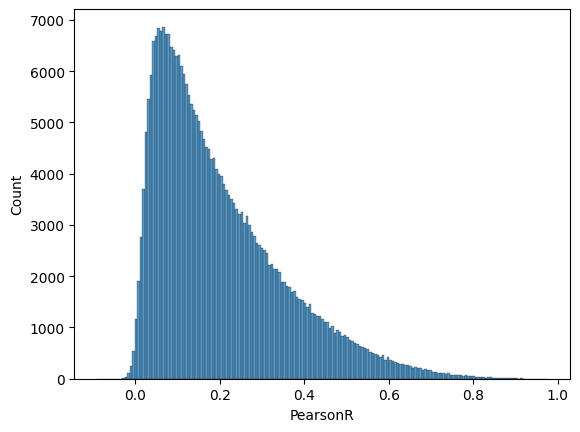

In [339]:
sns.histplot(CsvDf['PearsonR'])

In [ ]:
ResultList = []

i = fromCpgs
for SelectedCpg in list(CpgsGeneDict.keys())[fromCpgs:toCpgs]:   
    for model in models:        
        Model = model[1]
        SelectedGenes = len(ProteinCodCpgsAnnotations.loc[SelectedCpg][['transcriptIDs']])
        if SelectedGenes == 1:
            SelectedGenes = list(ProteinCodCpgsAnnotations.loc[SelectedCpg][['transcriptIDs']].values)
        else:
            SelectedGenes = ProteinCodCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].values
        Model.fit(TPMscaler.fit_transform(TrainTpm[SelectedGenes].fillna(0)), TrainMeth[SelectedCpg].fillna(0))  
        predictedMeth = Model.predict(TPMscaler.transform(ValTpm[SelectedGenes].fillna(0))) 
        resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[0], 
        "Euclidean Distance" : distance.euclidean(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
        'RMSE': root_mean_squared_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
        'MSE': mean_squared_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
        "MAE": mean_absolute_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
        "R2" : r2_score(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
        'P.Val' : stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[1], 
        'Model':model[0], 
        }
        ResultList.append(resultDict)
        pd.DataFrame(ResultList).to_csv(f'Results/EnsembleModel.{fromCpgs}.to.{toCpgs}.csv')

    if i % 100 == 0:    
        print(i ,"Out of " ,toCpgs)
    i += 1    

In [ ]:
def plotCPG(CPG, model, axis, CPgsGeneDict):
    Gene = CPgsGeneDict[CPG]
    QueryGene = pd.DataFrame()
    QueryGene['Gene'] = TestTPM[Gene]
    QueryGene.index = TestTPM.T.columns
    QueryGene.loc[:,"Group"] = QueryGene['Gene'].apply(lambda x: "High" if x > QueryGene['Gene'].median() else "Low")
    QueryGene.loc[:,"Meth"] =  TestMeth[CPG].values
    model.fit(TPMscaler.fit_transform(TrainTpm[Gene].fillna(0)), TrainMeth[CPG].fillna(0).values)
    predictedMeth = model.predict(TPMscaler.transform(TestTPM[Gene].fillna(0)))
    QueryGene.loc[:,"Pred Meth"] =  predictedMeth
    sns.boxplot(pd.melt(QueryGene[['Group','Meth','Pred Meth']], id_vars='Group'), x='variable', y='value', hue='Group', ax=axis)
    plt.tight_layout()

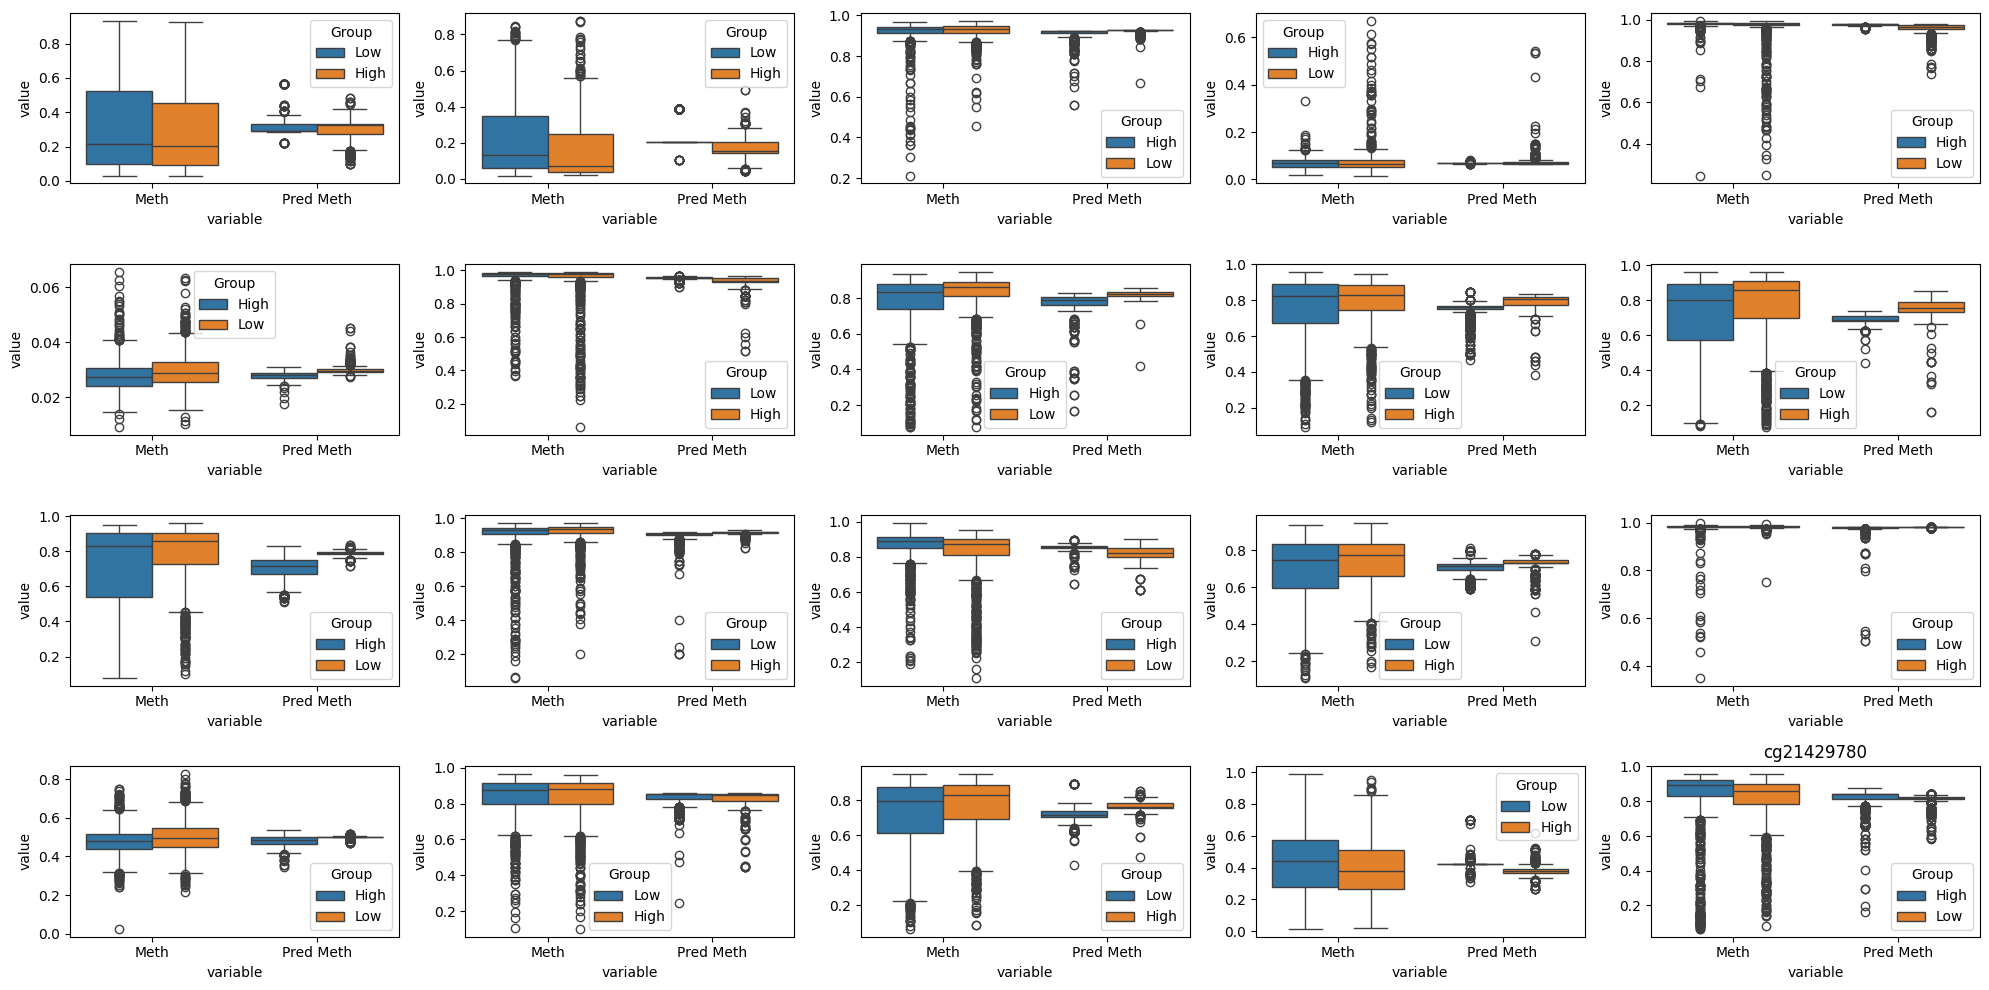

In [416]:
model = models[5][1]
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = list(axes.flatten())
i = 0
for cpgs in CsvDf[(CsvDf['PearsonR'] < 0.2) & (CsvDf['No.Genes'] == 1) & (CsvDf['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False).index[:20]:
    # print(cpgs)
    ax = plotCPG(cpgs, model, axes[i], CPgsGeneDict)
    plt.title(f'{cpgs}')
    i += 1

In [ ]:
model = models['GradientBoosting'][1]
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = list(axes.flatten())
i = 0
for cpgs in CsvDf[(CsvDf['PearsonR'] < 0.7) & (CsvDf['No.Genes'] == 1) & (CsvDf['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False).index[:20]:
    # print(cpgs)
    ax = plotCPG(cpgs, model, axes[i], CpgsGeneDict)
    plt.title(f'{cpgs}')
    i += 1

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

with open('CpgsGeneDict.pkl', 'rb') as f:
    CpgsGeneDict = pickle.load(f)
ResultList = []
i = 0

for SelectedCpg in GtexCommonCpgs:
    for model in models:        
        Model = model[1]
        Cpg = CpgsGeneDict[SelectedCpg][0]
        Genes = CpgsGeneDict[SelectedCpg][1]
        Model.fit(TPMscaler.fit_transform(TrainTpm[Genes].fillna(0)), TrainMeth[Cpg].fillna(0))  
        predictedMeth = Model.predict(TPMscaler.transform(ValTpm[Genes].fillna(0))) 
        resultDict = {'CPG':Cpg, "PearsonR":stats.pearsonr(predictedMeth,ValMeth[Cpg].fillna(0))[0], 
        "Euclidean Distance" : distance.euclidean(predictedMeth,ValMeth[Cpg].fillna(0)), 
        'MSE': mean_squared_error(predictedMeth,ValMeth[Cpg].fillna(0)),
        "MAE": mean_absolute_error(predictedMeth,ValMeth[Cpg].fillna(0)),
        "R2" : r2_score(predictedMeth,ValMeth[Cpg].fillna(0)), 
        'P.Val' : stats.pearsonr(predictedMeth,ValMeth[Cpg].fillna(0))[1], 
        'Model':model[0], "Genes":Genes, 
        }
        ResultList.append(resultDict)
    if i % 10 == 0:    
        print(i ,"Out of " ,30)
    i += 1    

In [52]:
CsvDf = pd.read_csv('/home/sbl/ansar/SBL.Backup/MethPred/MethPred/EnsembleAnalysis/Results.Combined.CPGS.csv')
CsvDf.set_index('CPG', inplace=True)
CsvDf = CsvDf[~ CsvDf.index.duplicated(keep='first')]
CsvDf = CsvDf[CsvDf['PearsonR'] >= 0.45]

In [ ]:
# Meth450Annotations = Meth450Annotations.loc[CsvDf.index]
Meth450Annotations.loc[:, 'genesUniq'] = Meth450Annotations['genesUniq'].str.split(';')
Meth450Annotations.explode(['genesUniq'])['genesUniq'].value_counts().index
Genes = list(Meth450Annotations.explode(['genesUniq'])['genesUniq'].value_counts().index)
Meth450Annotations = Meth450Annotations.explode('genesUniq')

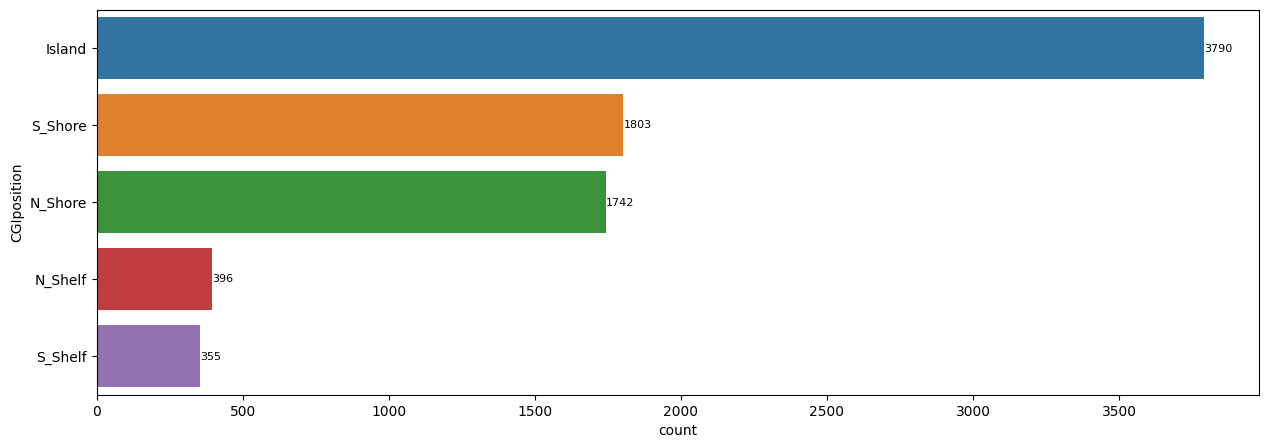

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(pd.DataFrame(Meth450Annotations['CGIposition'].value_counts()).reset_index(), x='count', y='CGIposition')
ax.bar_label(ax.containers[0], fontsize=8)
plt.show()
# pd.DataFrame(Meth450Annotations['CGIposition'].value_counts())

In [447]:
# import gseapy as gp
# enr = gp.enrichr(gene_list=topGenes, # or "./tests/data/gene_list.txt",
#                  gene_sets=['Reactome_2022','GO_Biological_Process_2023','GO_Molecular_Function_2023','GTEx_Aging_Signatures_2021'],
#                  organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
#                  outdir=None, # don't write to disk
#                 )

In [144]:
# enr.results[enr.results['Term'].str.contains('Immune')].head(30)

In [ ]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results[enr.results['Term'].str.contains('Immune')],
              column="P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              top_term=20,
              figsize=(10,20),
            #   title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

In [296]:
# CommonGenes = list(set(TCGAtpm.index).intersection(Genes))
# Meth450Annotations = Meth450Annotations[Meth450Annotations['genesUniq'].isin(CommonGenes)]
# MethTCGA = MethTCGA.loc[Meth450Annotations.index]
# TCGAtpm = TCGAtpm.loc[CommonGenes]
MethTCGA = MethTCGA.groupby(MethTCGA.columns, axis=1).mean()
Meth450Annotations.head()

,CpG_chrm,CpG_beg,CpG_end,probe_strand,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition
CPG,,,,,,,,,,,
cg27539721,chr12,101739587.0,101739589.0,+,SYCP3,CHPT1;CHPT1;SYCP3;SYCP3;SYCP3;SYCP3,protein_coding;protein_coding;protein_coding;p...,ENST00000546873.1;ENST00000552213.1;ENST000002...,13264;9;-161;-174;-118;-115,CGI:chr12:101738975-101739637,Island
cg27539721,chr12,101739587.0,101739589.0,+,CHPT1,CHPT1;CHPT1;SYCP3;SYCP3;SYCP3;SYCP3,protein_coding;protein_coding;protein_coding;p...,ENST00000546873.1;ENST00000552213.1;ENST000002...,13264;9;-161;-174;-118;-115,CGI:chr12:101738975-101739637,Island
cg09676606,chr12,101739093.0,101739095.0,-,SYCP3,CHPT1;CHPT1;SYCP3;SYCP3;SYCP3;SYCP3,protein_coding;protein_coding;protein_coding;p...,ENST00000546873.1;ENST00000552213.1;ENST000002...,12770;-485;333;320;376;379,CGI:chr12:101738975-101739637,Island
cg09676606,chr12,101739093.0,101739095.0,-,CHPT1,CHPT1;CHPT1;SYCP3;SYCP3;SYCP3;SYCP3,protein_coding;protein_coding;protein_coding;p...,ENST00000546873.1;ENST00000552213.1;ENST000002...,12770;-485;333;320;376;379,CGI:chr12:101738975-101739637,Island
cg10935064,chr12,101739568.0,101739570.0,+,SYCP3,CHPT1;CHPT1;SYCP3;SYCP3;SYCP3;SYCP3,protein_coding;protein_coding;protein_coding;p...,ENST00000546873.1;ENST00000552213.1;ENST000002...,13245;-10;-142;-155;-99;-96,CGI:chr12:101738975-101739637,Island


In [192]:
CPgsGeneDict = Meth450Annotations.groupby(Meth450Annotations.index)['genesUniq'].apply(list).to_dict()

In [260]:
# TCGAtpm = TCGAtpm.T
# MethTCGA = MethTCGA.T

In [310]:
TrainTpm, TestTpm, TrainMeth, ValMeth = train_test_split(TCGAtpm, MethTCGA, train_size=0.6, random_state=35)

In [338]:
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
scaler = StandardScaler()
master_list = []

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for cpgs in CPgsGeneDict.items():
    SelectedCpg = cpgs[0]
    SelectedTranscript = cpgs[1]
    X = scaler.fit_transform(TrainTpm[SelectedTranscript].fillna(0))
    y = TrainMeth[[SelectedCpg]].fillna(0)
    model = models[5][1]
    model.fit(X,y)
    predictedMeth = model.predict(scaler.transform(TestTpm[cpgs[1]].fillna(0)))
    master_list.append(
        {'CPG':cpgs[0], "PearsonR":stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[0], 
                    "Euclidean Distance" : distance.euclidean(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
                    'MSE': mean_squared_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
                    "MAE": mean_absolute_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
                    "R2" : r2_score(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
                    'P.Val' : stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[1], 
                    'Model':models[5][0]})
    pd.DataFrame(master_list).to_csv('Genes.CPGs.Prediction.csv')

In [ ]:
df = pd.DataFrame(master_list)
df = df.set_index('CPG')
df[(df['PearsonR'] > 0.5) & (df['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False)                                                

,PearsonR,Euclidean Distance,MSE,MAE,R2,P.Val,Model
CPG,,,,,,,
cg00063477,0.952075,7.837978,0.016822,0.075772,0.898711,0.000000e+00,GradientBoosting
cg00215587,0.868070,7.203815,0.014210,0.069890,0.683476,0.000000e+00,GradientBoosting
cg00221668,0.836028,6.569118,0.011816,0.082506,0.569268,0.000000e+00,GradientBoosting
cg00031256,0.819988,6.885941,0.012984,0.049647,0.524563,0.000000e+00,GradientBoosting
cg00032205,0.815898,8.608238,0.020291,0.112884,0.512011,0.000000e+00,GradientBoosting
...,...,...,...,...,...,...,...
cg00040312,0.518922,15.830088,0.068618,0.212438,-1.171288,5.636563e-251,GradientBoosting
cg00174500,0.512290,8.935105,0.021861,0.118194,-1.604554,1.381025e-243,GradientBoosting
cg00143998,0.511331,6.558908,0.011780,0.063445,-1.210071,1.567954e-242,GradientBoosting


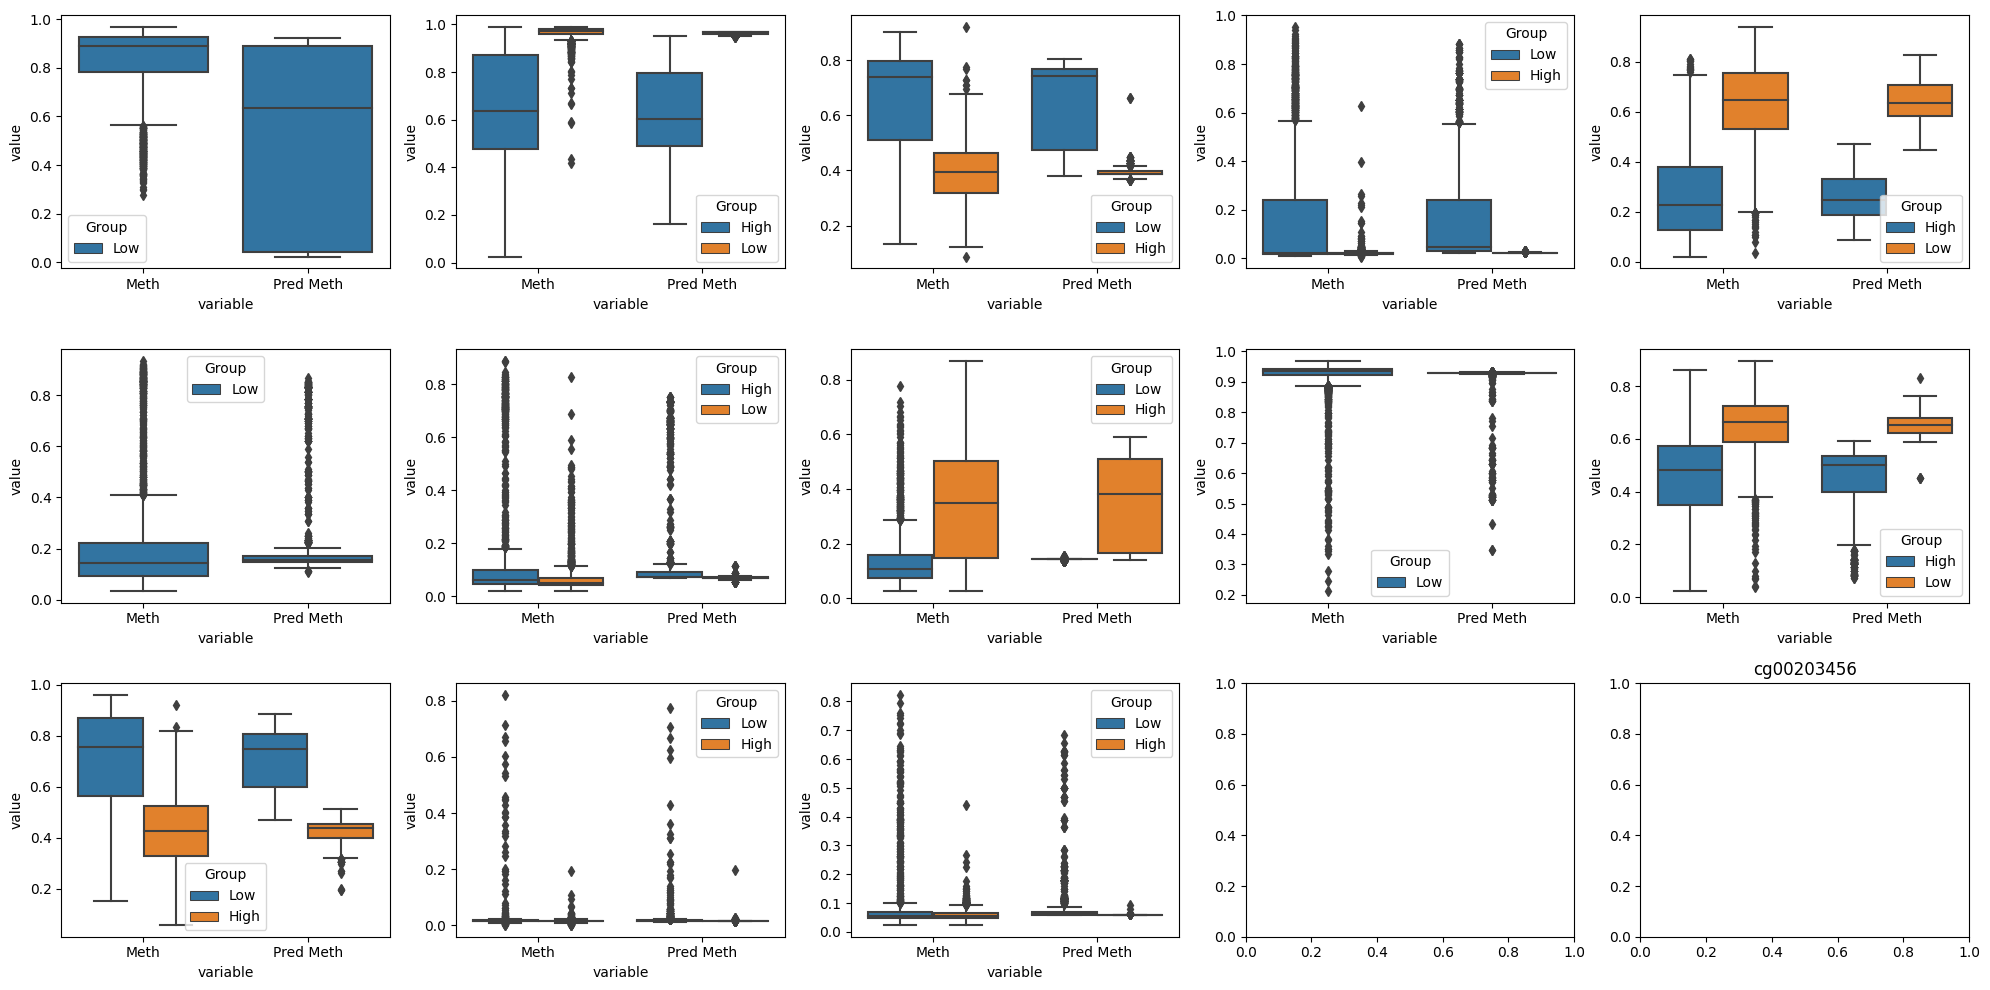

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = list(axes.flatten())
i = 0
for cpgs in df[(df['PearsonR'] > 0.7) & (df['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False).index[:15]:
    ax = plotCPG(cpgs, model, axes[i])
    plt.title(f'{cpgs}')
    i += 1